In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

d:\anaconda3\envs\lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = './archive/train.txt'
val_path = './archive/val.txt'
test_path = './archive/test.txt'

train_df = pd.read_csv(train_path, sep=';', names=['Text', 'Emotion'])
val_df = pd.read_csv(val_path, sep=';', names=['Text', 'Emotion'])
test_df = pd.read_csv(test_path, sep=';', names=['Text', 'Emotion'])

train_df = train_df.drop(train_df[(train_df['Emotion'] == 'surprise') | (train_df['Emotion'] == 'love')].index)
val_df = val_df.drop(val_df[(val_df['Emotion'] == 'surprise') | (val_df['Emotion'] == 'love')].index)
test_df = test_df.drop(test_df[(test_df['Emotion'] == 'surprise') | (test_df['Emotion'] == 'love')].index)



In [3]:
label_encoder = LabelEncoder()
train_df['Emotion'] = label_encoder.fit_transform(train_df['Emotion'])
val_df['Emotion'] = label_encoder.transform(val_df['Emotion'])
test_df['Emotion'] = label_encoder.transform(test_df['Emotion'])

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

def create_dataset(df):
    texts = df['Text'].tolist()
    labels = df['Emotion'].tolist()
    tokenized_data = tokenize_function(texts)
    encoded_labels = torch.tensor(labels)
    dataset = TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'], encoded_labels)
    return dataset

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_dataset = create_dataset(test_df)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [4]:
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\anaconda3\envs\lab\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    model.train()
    train_loss = 0
    correct_predictions_train = 0
    
    for batch in train_dataloader:
        input_ids, attention_masks, labels = batch
        batch = {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_masks.to(device),
            'labels': labels.to(device)
        }
        
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_predictions_train += (preds == batch['labels']).sum().item()
    
    train_loss /= len(train_dataloader)
    train_accuracy = correct_predictions_train / len(train_dataset)
   
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0
    correct_predictions_val = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_masks, labels = batch
            batch = {
                'input_ids': input_ids.to(device),
                'attention_mask': attention_masks.to(device),
                'labels': labels.to(device)
            }
            
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_predictions_val += (preds == batch['labels']).sum().item()
    
    val_loss /= len(val_dataloader)
    val_accuracy = correct_predictions_val / len(val_dataset)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/20
Train Loss: 0.3740, Train Accuracy: 0.8612
Val Loss: 0.1155, Val Accuracy: 0.9604
Epoch 2/20
Train Loss: 0.0678, Train Accuracy: 0.9747
Val Loss: 0.0818, Val Accuracy: 0.9678
Epoch 3/20
Train Loss: 0.0471, Train Accuracy: 0.9816
Val Loss: 0.0906, Val Accuracy: 0.9615
Epoch 4/20
Train Loss: 0.0377, Train Accuracy: 0.9855
Val Loss: 0.1146, Val Accuracy: 0.9644
Epoch 5/20
Train Loss: 0.0268, Train Accuracy: 0.9886
Val Loss: 0.1377, Val Accuracy: 0.9615
Epoch 6/20
Train Loss: 0.0228, Train Accuracy: 0.9910
Val Loss: 0.1181, Val Accuracy: 0.9650
Epoch 7/20
Train Loss: 0.0212, Train Accuracy: 0.9921
Val Loss: 0.1089, Val Accuracy: 0.9684
Epoch 8/20
Train Loss: 0.0178, Train Accuracy: 0.9928
Val Loss: 0.1263, Val Accuracy: 0.9713
Epoch 9/20
Train Loss: 0.0117, Train Accuracy: 0.9952
Val Loss: 0.1002, Val Accuracy: 0.9696
Epoch 10/20
Train Loss: 0.0084, Train Accuracy: 0.9972
Val Loss: 0.1249, Val Accuracy: 0.9747
Epoch 11/20
Train Loss: 0.0076, Train Accuracy: 0.9974
Val Loss: 0.12

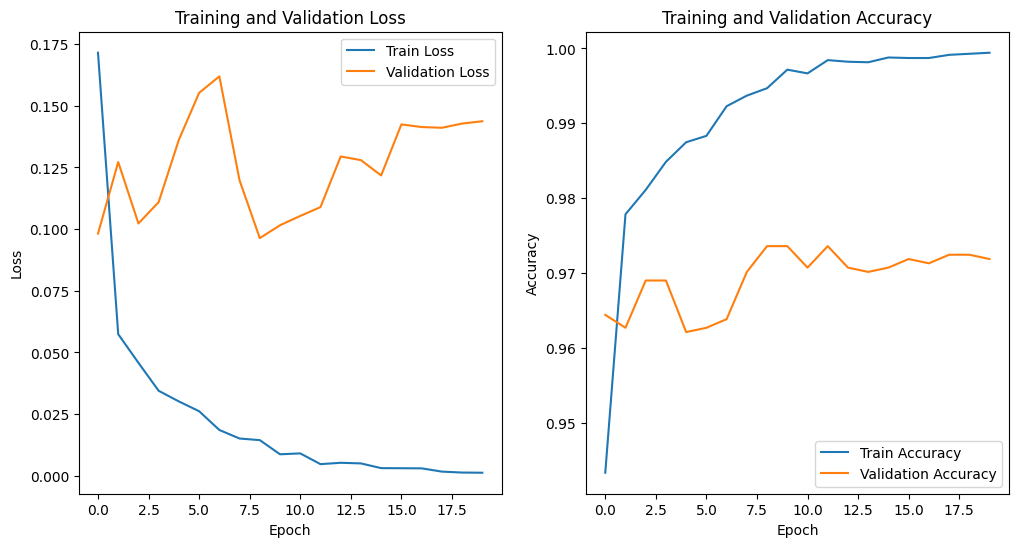

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [21]:
model.eval()
test_loss = 0
correct_predictions_test = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_masks, labels = batch
        batch = {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_masks.to(device),
            'labels': labels.to(device)
        }
        
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_predictions_test += (preds == batch['labels']).sum().item()

test_loss /= len(test_dataloader)
test_accuracy = correct_predictions_test / len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.1408, Test Accuracy: 0.9735


Test Loss: 0.1408, Test Accuracy: 0.9735


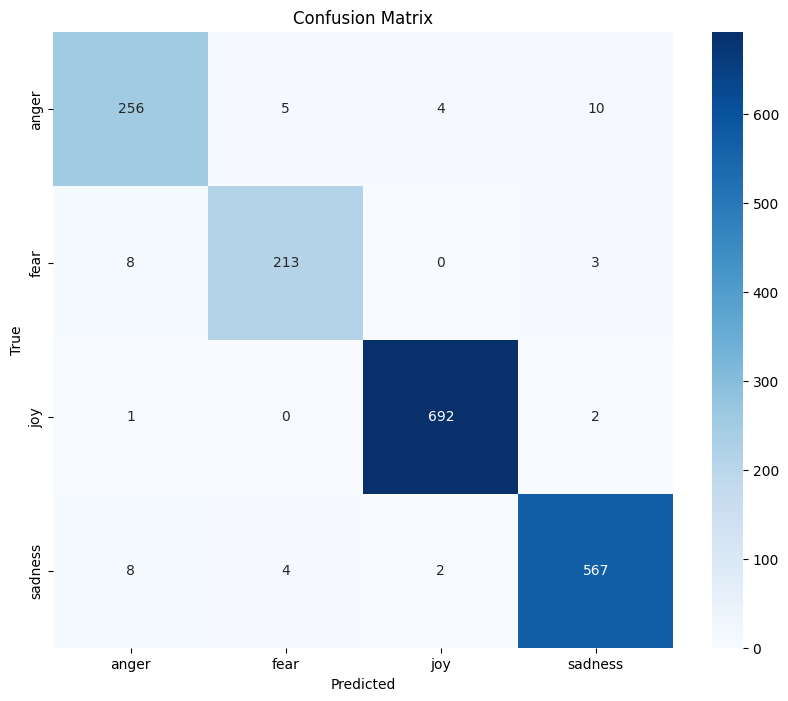

In [22]:
model.eval()
test_loss = 0
correct_predictions_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_predictions_test += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_dataloader)
test_accuracy = correct_predictions_test / len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [6]:
model.save_pretrained("./Model_C")
tokenizer.save_pretrained("./Model_C")

('./Model_C\\tokenizer_config.json',
 './Model_C\\special_tokens_map.json',
 './Model_C\\vocab.txt',
 './Model_C\\added_tokens.json')